In [1]:
# !pip install h5rdmtoolbox

# 1. Planning

- Decide to use HDF5 as your core file format
- Define important attributes and their usage in a metadata convention (e.g. a YAML file)
- Publish your convention on a repository like [Zenodo](https://zenodo.org/)

At this time we assume, that we have done this already, thus we'll be using a convention published on [Zenodo (doi/rec-id: 10156750)](https://zenodo.org/records/10156750), that already exists:

In [2]:
import h5rdmtoolbox as h5tbx
from h5rdmtoolbox.repository import zenodo

print(h5tbx.__version__)

zenodo_repo = zenodo.ZenodoRecord(10428822)
cv = h5tbx.convention.from_repo(zenodo_repo, 'tutorial_convention.yaml')

1.2.2


Another important step is defining the expected layout of a file. For this simple example, we "only" want to require users to provide the attribute "units" with every dataset:

In [3]:
from h5rdmtoolbox import layout
from h5rdmtoolbox import database

lay = layout.Layout()
spec_has_units = lay.add(
    database.FileDB.find,
    flt={'units': {'$exists': True}},
    objfilter='dataset'
)

# 2. Collecting

We start with writing data to an HDF5 file. This is syntactically almost like using `h5py`, just with a few features wrapped around it.

- Fill an HDF5 file with the required data and mandatory metadata
- Data may come in various sources, e.g. from a measurement, a simulation or a database
- HDF5 is best for multidimensional data, but can also be used for 1D data
- When writing the HDF5 files, the convention is automatically validating the metadata input, which are the attributes
  or the datasets and groups


Before we can start writing data to the file, we must enable the convention. This results in changing the behaviour of methods like `create_datasets` as they now require parameters like `units` for example:

In [4]:
# enable the convention:
h5tbx.use(cv)

using("h5rdmtoolbox-tutorial-convention")

In [5]:
filename = 'my_file.hdf'

import numpy as np

with h5tbx.File(filename,
                mode='w',
                data_type='experimental',
                contact='https://orcid.org/0000-0001-8729-0482') as h5:
    # create a dataset
    h5.create_dataset(name='time', data=np.linspace(0, 1, 1000),
                      standard_name='time', units='ms', make_scale=True)
    h5.create_dataset(name='u',
                      data=np.random.normal(10, 2, 1000),
                      standard_name='x_velocity',
                      units='m/s',
                      attach_scale='time')
    h5['u'].dims[0].attach_scale(h5['time'])

## Refining the metadata

We already provided quite some metadata with the file. Although, attributes like "units" is quite self-explaining, let's associate it with a persistent identifier. In this way, the metadata becomes *FAIR*. More on this can be found [here](https://h5rdmtoolbox.readthedocs.io/en/latest/userguide/wrapper/FAIRAttributes.html).

In [6]:
from h5rdmtoolbox.namespace import M4I, QUDT_UNIT

with h5tbx.File(filename, 'r+') as h5:
    h5.u.iri['units'].predicate = 'http://qudt.org/schema/qudt/Unit'
    h5.u.iri['units'].object = QUDT_UNIT.M_PER_SEC
    h5.iri['contact'].predicate = M4I.orcidId

In the next step, we will see one practical effect of assigning IRIs to the metadata.

# 3. Analyzing

Let's open the file, inspect its content and plot a dataset.

## 3.1 HDF content dump
Use the *dump()* method:

In [7]:
with h5tbx.File(filename, mode='r') as h5:
    # inspect the file layout and content:
    h5.dump(collapsed=False)

... or extract metadata as a JSON-LD file:

In [8]:
from h5rdmtoolbox import jsonld as h5tbxjld
print(h5tbxjld.dumps(filename, indent=2))

__h5rdmtoolbox_version__ 1.2.2
contact https://orcid.org/0000-0001-8729-0482
data_type experimental
standard_name_table https://zenodo.org/record/10428795
standard_name time
units ms
standard_name x_velocity
units m/s
{
  "@graph": [
    {
      "@id": "grp:/",
      "https://w3id.org/okn/o/sd#SoftwareVersion": "1.2.2",
      "http://w3id.org/nfdi4ing/metadata4ing#orcidId": "https://orcid.org/0000-0001-8729-0482",
      "data_type": "experimental",
      "standard_name_table": "https://zenodo.org/record/10428795"
    },
    {
      "@id": "grp:/time",
      "standard_name": "time",
      "units": "ms"
    },
    {
      "@id": "grp:/u",
      "standard_name": "x_velocity",
      "http://qudt.org/schema/qudt/Unit": "http://qudt.org/vocab/unit/M-PER-SEC"
    }
  ]
}


## 3.2 Plotting

First slice the dataset. We will receive a `xr.DataArray`:

In [9]:
with h5tbx.File(filename, mode='r') as h5:
    u = h5.u[:]
u

<xarray.DataArray 'u' (time: 1000)>
8.178 11.09 6.717 10.23 6.582 10.4 7.309 ... 9.54 9.158 12.77 11.11 7.811 9.28
Coordinates:
  * time     (time) float64 0.0 0.001001 0.002002 0.003003 ... 0.998 0.999 1.0
Attributes:
    IRI_OBJECT:     {'units': 'http://qudt.org/vocab/unit/M-PER-SEC'}
    IRI_PREDICATE:  {'units': 'http://qudt.org/schema/qudt/Unit'}
    standard_name:  x_velocity
    units:          m/s

Plot it using the conventional way by using `matplotlib`:

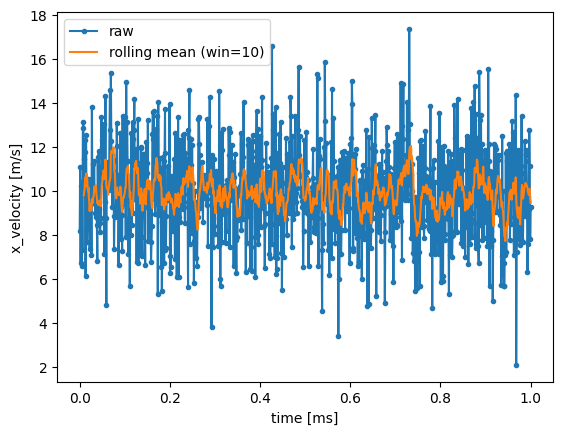

In [10]:
import matplotlib.pyplot as plt

plt.figure()
u.plot(marker='.', label='raw')
u.rolling(time=10).mean().plot(label='rolling mean (win=10)')
plt.legend()
plt.show()

... or do everything in just a few lines (now with a histogram) thanks to the `xrarray` library:

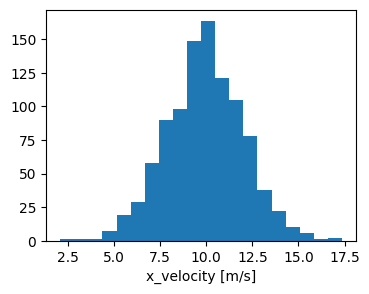

In [11]:
with h5tbx.File(filename, mode='r') as h5:
    plt.figure(figsize=(4, 3))
    h5.u[:].plot.hist(bins=20)
    plt.show()

# 4. Sharing your data on a repository

Sharing data is important. We want to upload our HDF5 file to Zenodo for long-time storage.

## 4.1 Validation
Before doing so, let's first check if the file fulfills the requirements, which we defined in the layout:

In [12]:
res = lay.validate(filename)
res.is_valid()

True

Yes it does. We can upload it.

## 4.2 Upload
Currently, only the interface class to [Zenodo](https://zenodo.org/) is implemented. It is a popular choice to publish open access data. To create and upload data, you must generate an API token. If you don't have it, skip the next step.

In [13]:
from h5rdmtoolbox.repository import zenodo
from h5rdmtoolbox.repository.h5metamapper import hdf2json

TOKEN = None  # replace with your token

if TOKEN:
    zenodo.set_api_token(TOKEN)
    repo = zenodo.ZenodoSandboxDeposit(None)  # create a new one are provide the record ID.
    # The method "upload_hdf_file" requires a mapper function which creates an additional file which only contains metadata of the file.
    # If the HDF5 file is verly large, the user can first download the metadata file (in our case a json file) and inspect the metadata before
    # downloading the full file
    repo.upload_hdf_file(filename, metamapper=hdf2json)

# 5. Reusing

 - Find the data by searching through a file director
 - The root folder is the parent of the created file

In [14]:
fdb = h5tbx.database.FileDB(filename)
fdb

Find exactly one file with "standard_name=x_velocity":

In [15]:
result = fdb.find_one({'standard_name': {'$eq': 'x_velocity'}})
result

<LDataset "/u" in "my_file.hdf" attrs=(units=m/s, standard_name=x_velocity)>

The variable "result" is the found dataset (class is `LDataset`, a wrapper around a closed HDF dataset)

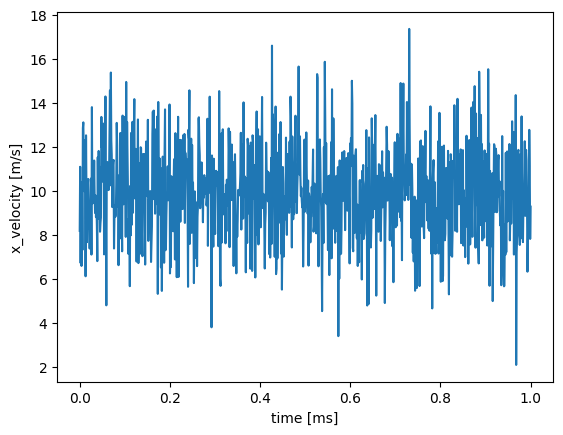

In [16]:
result[:].plot()